In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler


In [4]:
from google.colab import files
uploaded = files.upload()

KeyboardInterrupt: ignored

In [5]:
def load_data(col=None, path="/content/energy_dataset.csv", verbose=False):
    df = pd.read_csv(path)
    if col is not None:
        df = df[col]
    if verbose:
        print(df.head())
    return df

print("Multivariate Sample")
multivar_df = load_data(['time','total load actual', 'price actual'], verbose=True)

Multivariate Sample
                        time  total load actual  price actual
0  2015-01-01 00:00:00+01:00            25385.0         65.41
1  2015-01-01 01:00:00+01:00            24382.0         64.92
2  2015-01-01 02:00:00+01:00            22734.0         64.48
3  2015-01-01 03:00:00+01:00            21286.0         59.32
4  2015-01-01 04:00:00+01:00            20264.0         56.04


In [ ]:
df = load_data(col=["total load forecast","total load actual"])

#fill nans with linear interpolation because this is how we will fill when using the data in the models.
df_filled = df.interpolate("linear")
mm = MinMaxScaler()
df_scaled = mm.fit_transform(df_filled)

df_prep = pd.DataFrame(df_scaled, columns=df.columns)
y_true = df_prep["total load actual"]
y_pred_forecast = df_prep["total load forecast"]

### persistence 1 day
#shift series by 24 hours
# realign y_true to have the same length and time samples
y_preds_persistance_1_day = y_true.shift(24).dropna()
persistence_1_day_mae = tf.keras.losses.MAE(y_true[y_preds_persistance_1_day.index], y_preds_persistance_1_day).numpy()
persistence_1_day_mape = tf.keras.losses.MAPE(np.maximum(y_true[y_preds_persistance_1_day.index], 1e-5), np.maximum(y_preds_persistance_1_day, 1e-5)).numpy()


### persistence 3 day average
#shift by 1, 2, 3 days. Realign to have same lengths. Average days and calcualte MAE.

shift_dfs = list()
for i in range(1, 4):
    shift_dfs.append(pd.Series(y_true.shift(24 * i), name=f"d{i}"))

y_persistance_3d = pd.concat(shift_dfs, axis=1).dropna()
y_persistance_3d["avg"] = (y_persistance_3d["d1"] + y_persistance_3d["d2"] + y_persistance_3d["d3"])/3
d3_idx = y_persistance_3d.index
persistence_3day_avg_mae = tf.keras.losses.MAE(y_true[d3_idx], y_persistance_3d['avg']).numpy()
persistence_3day_avg_mape = tf.keras.losses.MAPE(np.maximum(y_true[d3_idx], 1e-5), np.maximum(y_persistance_3d['avg'], 1e-5)).numpy()


ref_error = pd.DataFrame({
    "Method": ["TSO Forecast", "Persistence 1 Day", "Persitence 3 Day Avg"],
    "MAE": [tf.keras.losses.MAE(y_true, y_pred_forecast).numpy(),
            persistence_1_day_mae,
            persistence_3day_avg_mae],
    "MAPE":[tf.keras.losses.MAPE(np.maximum(y_true, 1e-5), np.maximum(y_pred_forecast, 1e-5)).numpy(),
            persistence_1_day_mape,
            persistence_3day_avg_mape]}, 
    index=[i for i in range(3)])

print("\nSummary of Baseline Errors")
print(ref_error)
print(f"\nAverage error in MW for TSO Forecast {round(df['total load forecast'].mean()*ref_error.iloc[0,1], 2)}")

In [6]:
def clean_data(series):
    """Fills missing values. 
    
        Interpolate missing values with a linear approximation.
    """
    series_filled = series.interpolate(method='linear')
        
    return series_filled
        
    
def min_max_scale(dataframe):
    """ Applies MinMax Scaling
    
        Wrapper for sklearn's MinMaxScaler class.
    """
    mm = MinMaxScaler()
    return mm.fit_transform(dataframe)

In [7]:
def make_time_features(series):
    
    #convert series to datetimes
    times = series.apply(lambda x: x.split('+')[0])
    datetimes = pd.DatetimeIndex(times)
    
    hours = datetimes.hour.values
    day = datetimes.dayofweek.values
    months = datetimes.month.values
    
    hour = pd.Series(hours, name='hours')
    dayofw = pd.Series(day, name='dayofw')
    month = pd.Series(months, name='months')
    
    return hour, dayofw, month

hour, day, month = make_time_features(multivar_df.time)
print("Hours")
print(hour.head())
print("Day of Week")
print(day.head())
print("Months")
print(month.head())

Hours
0    0
1    1
2    2
3    3
4    4
Name: hours, dtype: int64
Day of Week
0    3
1    3
2    3
3    3
4    3
Name: dayofw, dtype: int64
Months
0    1
1    1
2    1
3    1
4    1
Name: months, dtype: int64


In [8]:
def split_data(series, train_fraq, test_len=8760):
    """Splits input series into train, val and test.
    
        Default to 1 year of test data.
    """
    #slice the last year of data for testing 1 year has 8760 hours
    test_slice = len(series)-test_len

    test_data = series[test_slice:]
    train_val_data = series[:test_slice]

    #make train and validation from the remaining
    train_size = int(len(train_val_data) * train_fraq)
    
    train_data = train_val_data[:train_size]
    val_data = train_val_data[train_size:]
    
    return train_data, val_data, test_data


multivar_df = clean_data(multivar_df)

#add hour and month features
hours, day, months = make_time_features(multivar_df.time)
multivar_df = pd.concat([multivar_df.drop(['time'], axis=1), hours, day, months], axis=1)

#scale
multivar_df = min_max_scale(multivar_df)
train_multi, val_multi, test_multi = split_data(multivar_df, train_fraq=0.65, test_len=8760)
print("Multivarate Datasets")
print(f"Train Data Shape: {train_multi.shape}")
print(f"Val Data Shape: {val_multi.shape}")
print(f"Test Data Shape: {test_multi.shape}")
print(f"Nulls In Train {np.any(np.isnan(train_multi))}")
print(f"Nulls In Validation {np.any(np.isnan(val_multi))}")
print(f"Nulls In Test {np.any(np.isnan(test_multi))}")

Multivarate Datasets
Train Data Shape: (17097, 5)
Val Data Shape: (9207, 5)
Test Data Shape: (8760, 5)
Nulls In Train False
Nulls In Validation False
Nulls In Test False


In [9]:
def window_dataset(data, n_steps, n_horizon, batch_size, shuffle_buffer, multi_var=False, expand_dims=False):
    """ Create a windowed tensorflow dataset
    
    """

    #create a window with n steps back plus the size of the prediction length
    window = n_steps + n_horizon
    
    #expand dimensions to 3D to fit with LSTM inputs
    #creat the inital tensor dataset
    if expand_dims:
        ds = tf.expand_dims(data, axis=-1)
        ds = tf.data.Dataset.from_tensor_slices(ds)
    else:
        ds = tf.data.Dataset.from_tensor_slices(data)
    
    #create the window function shifting the data by the prediction length
    ds = ds.window(window, shift=n_horizon, drop_remainder=True)
    
    #flatten the dataset and batch into the window size
    ds = ds.flat_map(lambda x : x.batch(window))
    ds = ds.shuffle(shuffle_buffer)    
    
    #create the supervised learning problem x and y and batch
    if multi_var:
        ds = ds.map(lambda x : (x[:-n_horizon], x[-n_horizon:, :1]))
    else:
        ds = ds.map(lambda x : (x[:-n_horizon], x[-n_horizon:]))
    
    ds = ds.batch(batch_size).prefetch(1)
    
    return ds

tf.random.set_seed(42)

n_steps = 72
n_horizon = 24
batch_size = 1
shuffle_buffer = 100


ds = window_dataset(train_multi, n_steps, n_horizon, batch_size, shuffle_buffer, multi_var=True)

print('Example sample shapes')
for idx,(x,y) in enumerate(ds):
    print("x = ", x.numpy().shape)
    print("y = ", y.numpy().shape)
    break


Example sample shapes
x =  (1, 72, 5)
y =  (1, 24, 1)


In [10]:
def build_dataset(train_fraq=0.65, 
                  n_steps=24*30, 
                  n_horizon=24, 
                  batch_size=256, 
                  shuffle_buffer=500, 
                  expand_dims=False, 
                  multi_var=False):
    """If multi variate then first column is always the column from which the target is contstructed.
    """
    
    tf.random.set_seed(23)
    
    if multi_var:
        data = load_data(col=['time', 'total load actual', 'price actual'])
        hours, day, months = make_time_features(data.time)
        data = pd.concat([data.drop(['time'], axis=1), hours, day, months], axis=1)
    else:
        data = load_data(col=['total load actual'])
        
    data = clean_data(data)
    
    if multi_var:
        mm = MinMaxScaler()
        data = mm.fit_transform(data)
    
    train_data, val_data, test_data = split_data(data, train_fraq=train_fraq, test_len=8760)
    
    train_ds = window_dataset(train_data, n_steps, n_horizon, batch_size, shuffle_buffer, multi_var=multi_var, expand_dims=expand_dims)
    val_ds = window_dataset(val_data, n_steps, n_horizon, batch_size, shuffle_buffer, multi_var=multi_var, expand_dims=expand_dims)
    test_ds = window_dataset(test_data, n_steps, n_horizon, batch_size, shuffle_buffer, multi_var=multi_var, expand_dims=expand_dims)
    
    
    print(f"Prediction lookback (n_steps): {n_steps}")
    print(f"Prediction horizon (n_horizon): {n_horizon}")
    print(f"Batch Size: {batch_size}")
    print("Datasets:")
    print(train_ds.element_spec)
    
    return train_ds, val_ds, test_ds

train_ds, val_ds, test_ds = build_dataset(multi_var=True)

Prediction lookback (n_steps): 720
Prediction horizon (n_horizon): 24
Batch Size: 256
Datasets:
(TensorSpec(shape=(None, None, 5), dtype=tf.float64, name=None), TensorSpec(shape=(None, None, 1), dtype=tf.float64, name=None))


In [11]:
def get_params(multivar=False):
    lr = 3e-4
    n_steps=24*30
    n_horizon=24
    if multivar:
        n_features=5
    else:
        n_features=1
        
    return n_steps, n_horizon, n_features, lr

model_configs = dict()

def cfg_model_run(model, history, test_ds):
    return {"model": model, "history" : history, "test_ds": test_ds}


def run_model(model_name, model_func, model_configs, epochs):
    
    n_steps, n_horizon, n_features, lr = get_params(multivar=True)
    train_ds, val_ds, test_ds = build_dataset(n_steps=n_steps, n_horizon=n_horizon, multi_var=True)

    model = model_func(n_steps, n_horizon, n_features, lr=lr)

    model_hist = model.fit(train_ds, validation_data=val_ds, epochs=epochs)

    model_configs[model_name] = cfg_model_run(model, model_hist, test_ds)
    return test_ds

In [12]:
def dnn_model(n_steps, n_horizon, n_features, lr):
    tf.keras.backend.clear_session()
    
    model = tf.keras.models.Sequential([
        tf.keras.layers.Flatten(input_shape=(n_steps, n_features)),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Dense(n_horizon)
    ], name='dnn')
    
    loss=tf.keras.losses.Huber()
    optimizer = tf.keras.optimizers.Adam(lr=lr)
    
    model.compile(loss=loss, optimizer='adam', metrics=['mae'])
    
    return model


dnn = dnn_model(*get_params(multivar=True))
dnn.summary()

Model: "dnn"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 3600)              0         
                                                                 
 dense (Dense)               (None, 128)               460928    
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 128)               16512     
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_2 (Dense)             (None, 24)                3096      
                                                                 
Total params: 480,536
Trainable params: 480,536
Non-trainable p

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [13]:
def cnn_model(n_steps, n_horizon, n_features, lr=3e-4):
    
    tf.keras.backend.clear_session()
    
    model = tf.keras.models.Sequential([
        tf.keras.layers.Conv1D(64, kernel_size=6, activation='relu', input_shape=(n_steps,n_features)),
        tf.keras.layers.MaxPooling1D(2),
        tf.keras.layers.Conv1D(64, kernel_size=3, activation='relu'),
        tf.keras.layers.MaxPooling1D(2),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Dense(128),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Dense(n_horizon)
    ], name="CNN")
    
    loss= tf.keras.losses.Huber()
    optimizer = tf.keras.optimizers.Adam(lr=lr)
    
    model.compile(loss=loss, optimizer='adam', metrics=['mae'])
    
    return model

cnn = cnn_model(*get_params(multivar=True))
cnn.summary()


Model: "CNN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 715, 64)           1984      
                                                                 
 max_pooling1d (MaxPooling1D  (None, 357, 64)          0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 355, 64)           12352     
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 177, 64)          0         
 1D)                                                             
                                                                 
 flatten (Flatten)           (None, 11328)             0         
                                                                 
 dropout (Dropout)           (None, 11328)             0       

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [14]:
def lstm_model(n_steps, n_horizon, n_features, lr):
    
    tf.keras.backend.clear_session()
    
    model = tf.keras.models.Sequential([
        tf.keras.layers.LSTM(72, activation='relu', input_shape=(n_steps, n_features), return_sequences=True),
        tf.keras.layers.LSTM(48, activation='relu', return_sequences=False),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Dense(n_horizon)
    ], name='lstm')
    
    loss = tf.keras.losses.Huber()
    optimizer = tf.keras.optimizers.Adam(lr=lr)
    
    model.compile(loss=loss, optimizer='adam', metrics=['mae'])
    
    return model

lstm = lstm_model(*get_params(multivar=True))
lstm.summary()


Model: "lstm"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 720, 72)           22464     
                                                                 
 lstm_1 (LSTM)               (None, 48)                23232     
                                                                 
 flatten (Flatten)           (None, 48)                0         
                                                                 
 dropout (Dropout)           (None, 48)                0         
                                                                 
 dense (Dense)               (None, 128)               6272      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 24)                3096   

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [15]:
def lstm_cnn_model(n_steps, n_horizon, n_features, lr):
    
    tf.keras.backend.clear_session()
    
    model = tf.keras.models.Sequential([
        tf.keras.layers.Conv1D(64, kernel_size=6, activation='relu', input_shape=(n_steps,n_features)),
        tf.keras.layers.MaxPooling1D(2),
        tf.keras.layers.Conv1D(64, kernel_size=3, activation='relu'),
        tf.keras.layers.MaxPooling1D(2),
        tf.keras.layers.LSTM(72, activation='relu', return_sequences=True),
        tf.keras.layers.LSTM(48, activation='relu', return_sequences=False),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Dense(128),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Dense(n_horizon)
    ], name="lstm_cnn")
    
    loss = tf.keras.losses.Huber()
    optimizer = tf.keras.optimizers.Adam(lr=lr)
    
    model.compile(loss=loss, optimizer='adam', metrics=['mae'])
    
    return model

lstm_cnn = lstm_cnn_model(*get_params(multivar=True))
lstm_cnn.summary()


Model: "lstm_cnn"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 715, 64)           1984      
                                                                 
 max_pooling1d (MaxPooling1D  (None, 357, 64)          0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 355, 64)           12352     
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 177, 64)          0         
 1D)                                                             
                                                                 
 lstm (LSTM)                 (None, 177, 72)           39456     
                                                                 
 lstm_1 (LSTM)               (None, 48)                232

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [16]:
def lstm_cnn_skip_model(n_steps, n_horizon, n_features, lr):
    
    tf.keras.backend.clear_session()
    
   
    inputs = tf.keras.layers.Input(shape=(n_steps,n_features), name='main')
    
    conv1 = tf.keras.layers.Conv1D(64, kernel_size=6, activation='relu')(inputs)
    max_pool_1 = tf.keras.layers.MaxPooling1D(2)(conv1)
    conv2 = tf.keras.layers.Conv1D(64, kernel_size=3, activation='relu')(max_pool_1)
    max_pool_2 = tf.keras.layers.MaxPooling1D(2)(conv2)
    lstm_1 = tf.keras.layers.LSTM(72, activation='relu', return_sequences=True)(max_pool_2)
    lstm_2 = tf.keras.layers.LSTM(48, activation='relu', return_sequences=False)(lstm_1)
    flatten = tf.keras.layers.Flatten()(lstm_2)
    
    skip_flatten = tf.keras.layers.Flatten()(inputs)

    concat = tf.keras.layers.Concatenate(axis=-1)([flatten, skip_flatten])
    drop_1 = tf.keras.layers.Dropout(0.3)(concat)
    dense_1 = tf.keras.layers.Dense(128, activation='relu')(drop_1)
    drop_2 = tf.keras.layers.Dropout(0.3)(dense_1)
    output = tf.keras.layers.Dense(n_horizon)(drop_2)
    
    model = tf.keras.Model(inputs=inputs, outputs=output, name='lstm_skip')
    
    loss = tf.keras.losses.Huber()
    optimizer = tf.keras.optimizers.Adam(lr=lr)
    
    model.compile(loss=loss, optimizer='adam', metrics=['mae'])
    
    return model

lstm_skip = lstm_cnn_skip_model(*get_params(multivar=True))
lstm_skip.summary()


Model: "lstm_skip"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 main (InputLayer)              [(None, 720, 5)]     0           []                               
                                                                                                  
 conv1d (Conv1D)                (None, 715, 64)      1984        ['main[0][0]']                   
                                                                                                  
 max_pooling1d (MaxPooling1D)   (None, 357, 64)      0           ['conv1d[0][0]']                 
                                                                                                  
 conv1d_1 (Conv1D)              (None, 355, 64)      12352       ['max_pooling1d[0][0]']          
                                                                                          

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


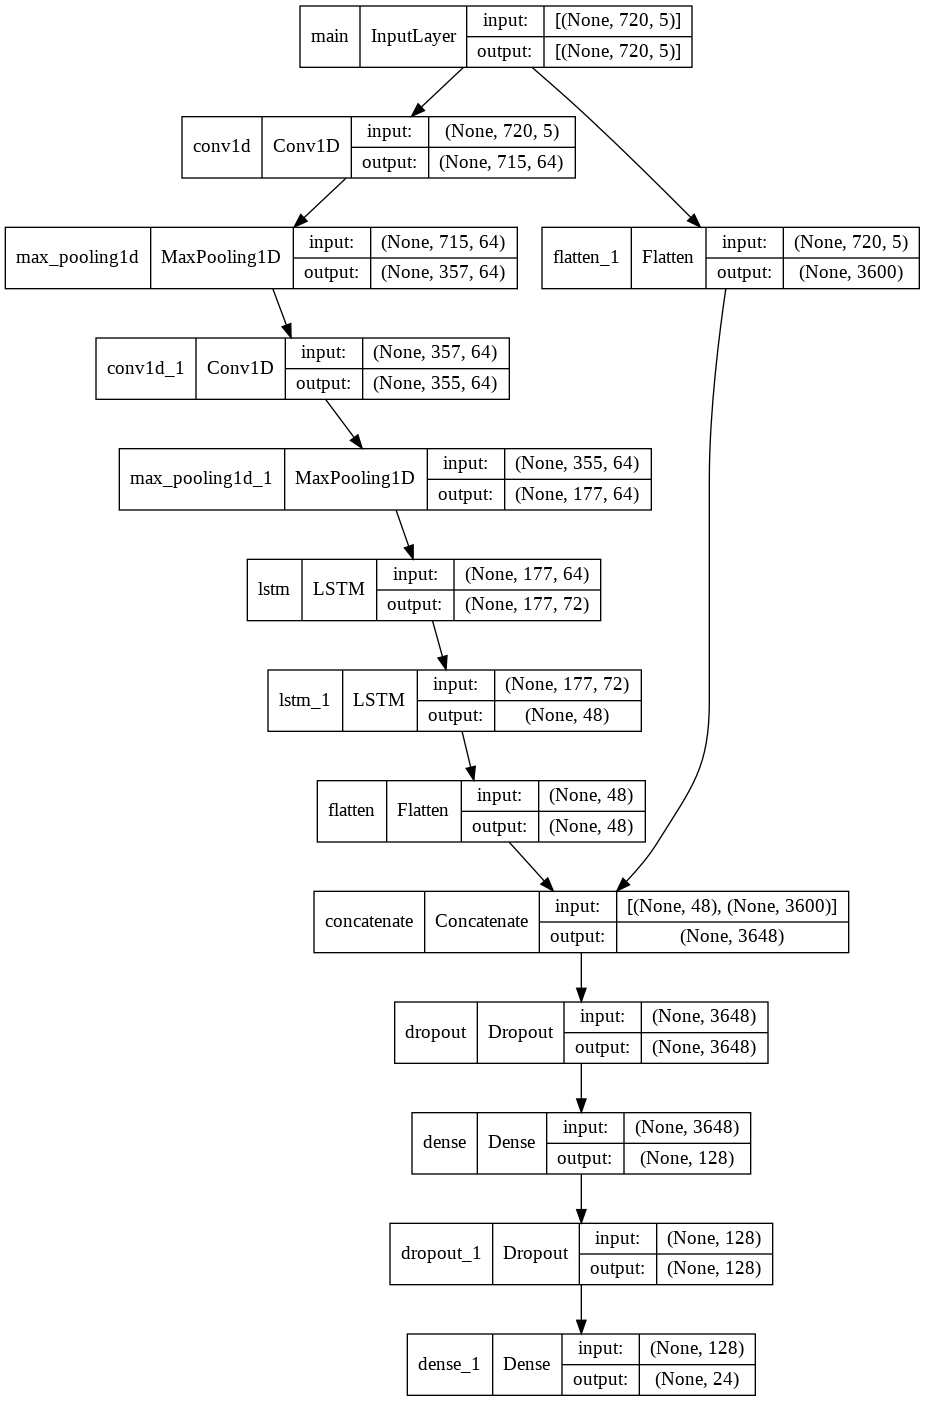

In [17]:
tf.keras.utils.plot_model(lstm_skip, show_shapes=True)


In [18]:
model_configs=dict()
run_model("dnn", dnn_model, model_configs, epochs=150)
run_model("cnn", cnn_model, model_configs, epochs=150)
run_model("lstm", lstm_model, model_configs, epochs=150)
run_model("lstm_cnn", lstm_cnn_model, model_configs, epochs=150)
run_model("lstm_skip", lstm_cnn_skip_model, model_configs, epochs=150)

Prediction lookback (n_steps): 720
Prediction horizon (n_horizon): 24
Batch Size: 256
Datasets:
(TensorSpec(shape=(None, None, 5), dtype=tf.float64, name=None), TensorSpec(shape=(None, None, 1), dtype=tf.float64, name=None))
Epoch 1/150


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


3/3 [==============================] - 2s 264ms/step - loss: 0.3155 - mae: 0.6676 - val_loss: 0.1295 - val_mae: 0.4319
Epoch 2/150
3/3 [==============================] - 1s 177ms/step - loss: 0.1125 - mae: 0.4143 - val_loss: 0.1000 - val_mae: 0.3806
Epoch 3/150
3/3 [==============================] - 1s 217ms/step - loss: 0.0898 - mae: 0.3546 - val_loss: 0.0857 - val_mae: 0.3283
Epoch 4/150
3/3 [==============================] - 2s 379ms/step - loss: 0.0781 - mae: 0.3243 - val_loss: 0.0750 - val_mae: 0.3074
Epoch 5/150
3/3 [==============================] - 2s 330ms/step - loss: 0.0656 - mae: 0.2931 - val_loss: 0.0623 - val_mae: 0.2794
Epoch 6/150
3/3 [==============================] - 2s 389ms/step - loss: 0.0588 - mae: 0.2765 - val_loss: 0.0577 - val_mae: 0.2700
Epoch 7/150
3/3 [==============================] - 2s 390ms/step - loss: 0.0506 - mae: 0.2540 - val_loss: 0.0499 - val_mae: 0.2522
Epoch 8/150
3/3 [==============================] - 2s 431ms/step - loss: 0.0438 - mae: 0.2353 -

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


3/3 [==============================] - 3s 753ms/step - loss: 0.4996 - mae: 0.8763 - val_loss: 0.1168 - val_mae: 0.3779
Epoch 2/150
3/3 [==============================] - 2s 633ms/step - loss: 0.1442 - mae: 0.4342 - val_loss: 0.1599 - val_mae: 0.4695
Epoch 3/150
3/3 [==============================] - 2s 615ms/step - loss: 0.1309 - mae: 0.4217 - val_loss: 0.0948 - val_mae: 0.3740
Epoch 4/150
3/3 [==============================] - 2s 617ms/step - loss: 0.0708 - mae: 0.3099 - val_loss: 0.0681 - val_mae: 0.3083
Epoch 5/150
3/3 [==============================] - 2s 611ms/step - loss: 0.0453 - mae: 0.2360 - val_loss: 0.0466 - val_mae: 0.2535
Epoch 6/150
3/3 [==============================] - 2s 604ms/step - loss: 0.0327 - mae: 0.2025 - val_loss: 0.0353 - val_mae: 0.2240
Epoch 7/150
3/3 [==============================] - 2s 647ms/step - loss: 0.0244 - mae: 0.1753 - val_loss: 0.0400 - val_mae: 0.2323
Epoch 8/150
3/3 [==============================] - 2s 623ms/step - loss: 0.0235 - mae: 0.1719 -

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 1/150
3/3 [==============================] - 14s 4s/step - loss: 0.1196 - mae: 0.4498 - val_loss: 0.1271 - val_mae: 0.4608
Epoch 2/150
3/3 [==============================] - 10s 3s/step - loss: 0.1107 - mae: 0.4294 - val_loss: 0.1184 - val_mae: 0.4402
Epoch 3/150
3/3 [==============================] - 10s 3s/step - loss: 0.0998 - mae: 0.4021 - val_loss: 0.1059 - val_mae: 0.4071
Epoch 4/150
3/3 [==============================] - 10s 3s/step - loss: 0.0846 - mae: 0.3597 - val_loss: 0.0862 - val_mae: 0.3509
Epoch 5/150
3/3 [==============================] - 10s 3s/step - loss: 0.0655 - mae: 0.2989 - val_loss: 0.0617 - val_mae: 0.2822
Epoch 6/150
3/3 [==============================] - 10s 3s/step - loss: 0.0561 - mae: 0.2674 - val_loss: 0.0539 - val_mae: 0.2619
Epoch 7/150
3/3 [==============================] - 10s 3s/step - loss: 0.0418 - mae: 0.2316 - val_loss: 0.0523 - val_mae: 0.2586
Epoch 8/150
3/3 [==============================] - 10s 3s/step - loss: 0.0337 - mae: 0.2084 - val

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 1/150
3/3 [==============================] - 8s 2s/step - loss: 0.1108 - mae: 0.4277 - val_loss: 0.1043 - val_mae: 0.4091
Epoch 2/150
3/3 [==============================] - 5s 1s/step - loss: 0.0831 - mae: 0.3568 - val_loss: 0.0572 - val_mae: 0.2793
Epoch 3/150
3/3 [==============================] - 5s 1s/step - loss: 0.0536 - mae: 0.2658 - val_loss: 0.0390 - val_mae: 0.2237
Epoch 4/150
3/3 [==============================] - 5s 1s/step - loss: 0.0389 - mae: 0.2230 - val_loss: 0.0413 - val_mae: 0.2329
Epoch 5/150
3/3 [==============================] - 5s 1s/step - loss: 0.0309 - mae: 0.1998 - val_loss: 0.0411 - val_mae: 0.2367
Epoch 6/150
3/3 [==============================] - 5s 1s/step - loss: 0.0274 - mae: 0.1879 - val_loss: 0.0418 - val_mae: 0.2442
Epoch 7/150
3/3 [==============================] - 5s 2s/step - loss: 0.0244 - mae: 0.1761 - val_loss: 0.0396 - val_mae: 0.2355
Epoch 8/150
3/3 [==============================] - 5s 1s/step - loss: 0.0211 - mae: 0.1636 - val_loss: 0

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 1/150
3/3 [==============================] - 9s 2s/step - loss: 0.5284 - mae: 0.9070 - val_loss: 0.0976 - val_mae: 0.3815
Epoch 2/150
3/3 [==============================] - 5s 1s/step - loss: 0.1078 - mae: 0.3998 - val_loss: 0.1087 - val_mae: 0.4111
Epoch 3/150
3/3 [==============================] - 5s 1s/step - loss: 0.0880 - mae: 0.3549 - val_loss: 0.0662 - val_mae: 0.3037
Epoch 4/150
3/3 [==============================] - 5s 1s/step - loss: 0.0834 - mae: 0.3282 - val_loss: 0.0629 - val_mae: 0.2961
Epoch 5/150
3/3 [==============================] - 5s 1s/step - loss: 0.0800 - mae: 0.3287 - val_loss: 0.0769 - val_mae: 0.3330
Epoch 6/150
3/3 [==============================] - 5s 1s/step - loss: 0.0783 - mae: 0.3241 - val_loss: 0.0621 - val_mae: 0.2958
Epoch 7/150
3/3 [==============================] - 5s 1s/step - loss: 0.0713 - mae: 0.3026 - val_loss: 0.0572 - val_mae: 0.2794
Epoch 8/150
3/3 [==============================] - 5s 2s/step - loss: 0.0697 - mae: 0.3009 - val_loss: 0

<PrefetchDataset shapes: ((None, None, 5), (None, None, 1)), types: (tf.float64, tf.float64)>

Loss Curves


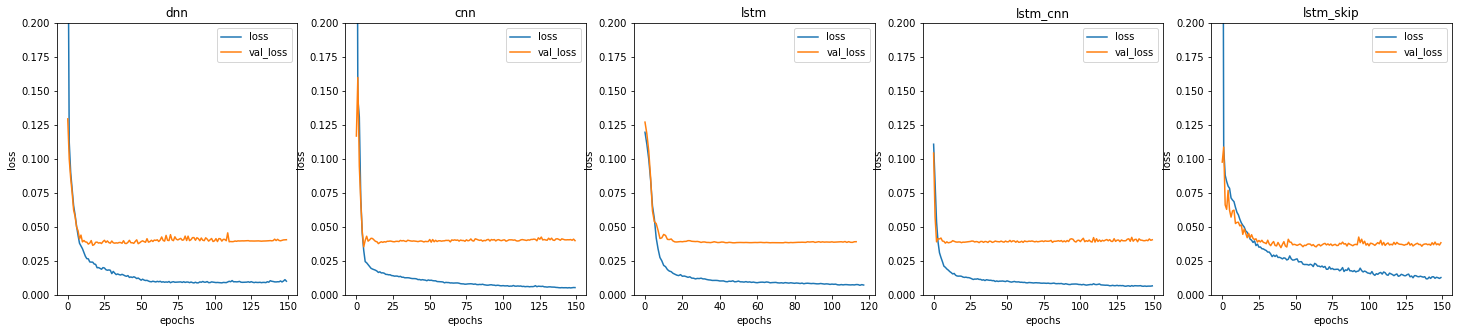

In [19]:
legend = list()

fig, axs = plt.subplots(1, 5, figsize=(25,5))

def plot_graphs(metric, val, ax, upper):
    ax.plot(val['history'].history[metric])
    ax.plot(val['history'].history[f'val_{metric}'])
    ax.set_title(key)
    ax.legend([metric, f"val_{metric}"])
    ax.set_xlabel('epochs')
    ax.set_ylabel(metric)
    ax.set_ylim([0, upper])
    
for (key, val), ax in zip(model_configs.items(), axs.flatten()):
    plot_graphs('loss', val, ax, 0.2)
print("Loss Curves")

MAE Curves


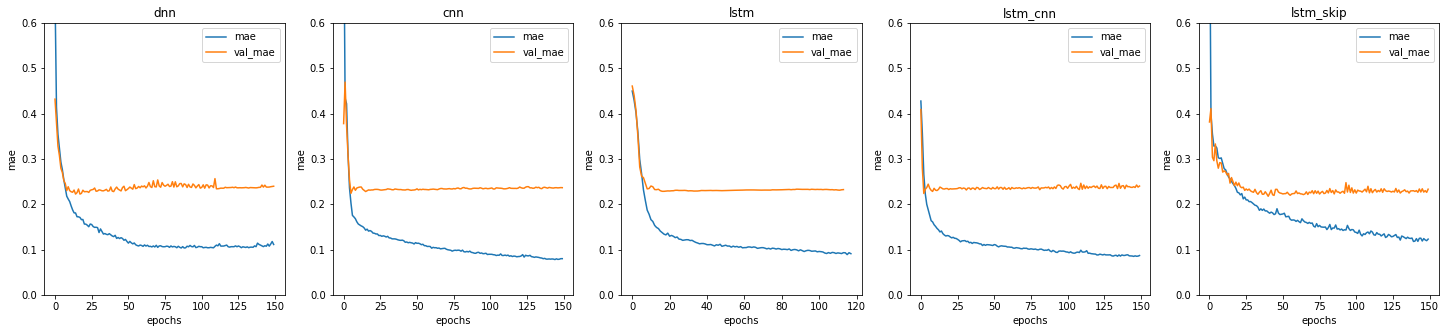

In [20]:
print("MAE Curves")
fig, axs = plt.subplots(1, 5, figsize=(25,5))
for (key, val), ax in zip(model_configs.items(), axs.flatten()):
    plot_graphs('mae', val, ax, 0.6)

First Two Weeks of Predictions


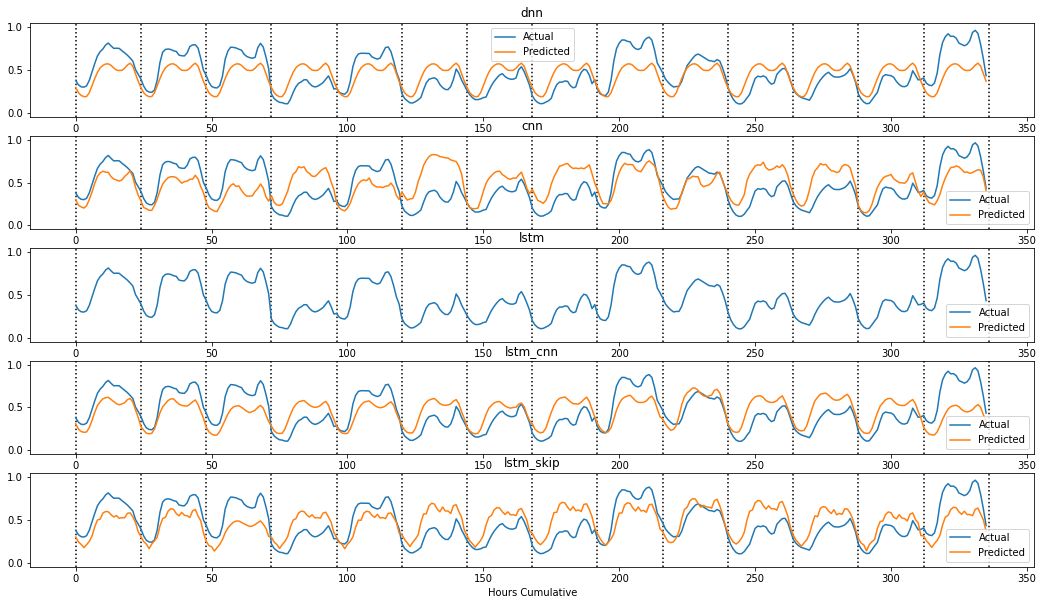

In [21]:
fig, axs = plt.subplots(5, 1, figsize=(18, 10))
days = 14

vline = np.linspace(0, days*24, days+1)

for (key, val), ax in zip(model_configs.items(), axs):

    test = val['test_ds']
    preds = val['model'].predict(test)

    xbatch, ybatch = iter(test).get_next()

    ax.plot(ybatch.numpy()[:days].reshape(-1))
    ax.plot(preds[:days].reshape(-1))
    ax.set_title(key)
    ax.vlines(vline, ymin=0, ymax=1, linestyle='dotted', transform = ax.get_xaxis_transform())
    ax.legend(["Actual", "Predicted"])

plt.xlabel("Hours Cumulative")
print('First Two Weeks of Predictions')